In [1]:
from dolfin import *
from rbnics import *
from mshr import *
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Poroelasticity(ParabolicCoerciveProblem):

    # Default initialization of members
    def __init__(self, V, **kwargs):
        # Call the standard initialization
        ParabolicCoerciveProblem.__init__(self, V, **kwargs)
        # ... and also store FEniCS data structures for assembly
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        U = TrialFunction(V)
        (self.µ, self.u) = split(U)
        V_ = TestFunction(V)
        (self.q, self.v) = split(V_)
        self.dx = Measure("dx")(subdomain_data=self.subdomains)
        self.ds = Measure("ds")(subdomain_data=self.boundaries)
        self.µ_init = -0.3124
        self.µ_swell = -0.001
        self.alpha = 0.66  # value for robin boundary coefficient
        # Store the initial condition expression
        self.ic = project(InitialConditions(), self.V)

    # Return custom problem name
    def name(self):
        return "GelsMOR_Bar_nestedPOD_0515"

    # Return theta multiplicative terms of the affine expansion of the problem.
    def compute_theta(self, term):
        mu = self.mu
        if term == "m":
            theta_m0 = 1.
            return (theta_m0, )
        elif term == "a":
            theta_a0 = 2.
            theta_a1 = mu[0]
            theta_a2 = -mu[1]
            theta_a3 = 1.
            theta_a4 = self.alpha
            return (theta_a0, theta_a1, theta_a2, theta_a3,theta_a4,)
        elif term == "f":
            theta_f0 = self.alpha * self.µ_swell
            theta_f1 = -mu[1] * self.µ_init
            return (theta_f0,theta_f1,)
        elif term == "initial_condition":
            # Create intial conditions and interpolate
            u_init = 1.0
            theta_ic0 = u_init
            return (theta_ic0,)
        else:
            raise ValueError("Invalid term for compute_theta().")

    # Return forms resulting from the discretization of the affine expansion of the problem operators.
    def assemble_operator(self, term):
        v = self.v
        q = self.q
        dx = self.dx
        if term == "m":
            u = self.u
            m0 = tr( sym( grad(u)) )* q * dx
            return (m0,)
        elif term == "a":
            u = self.u
            µ = self.µ
            ds = self.ds
            alpha = self.alpha
            # sig = 2*sym(grad(u)) + ( lmbda*tr(sym(grad(u))) - A*(µ-µ_swell) )*Identity(mesh.topology().dim())
            # sig = self.elasticity(lmbda, A, u, µ)
            a0 = inner( sym(grad(u)), sym(grad(v)) ) * dx
            a1 = inner(tr(sym(grad(u))) * Identity(mesh.topology().dim()), sym(grad(v)) ) * dx
            a2 = inner(µ*Identity(mesh.topology().dim()), sym(grad(v)) ) * dx
            a3 = dot(grad(µ), grad(q)) * dx
            a4 = µ * q* ds(3) +  µ * q* ds(2)
            return (a0, a1, a2, a3, a4,)
        elif term == "f":
            ds = self.ds
            f0 = q * ds(2) + q * ds(3)
            f1 = inner( Identity(mesh.topology().dim()), sym(grad(v)) )*dx
            return (f0,f1,)
        elif term == "initial_condition":
            ic0 = self.ic
            return (ic0,)
        elif term == "dirichlet_bc":
            bc0 = [DirichletBC(self.V.sub(0).sub(1), Constant(0.0), self.boundaries, 4), DirichletBC(self.V.sub(0).sub(0), Constant(0.0), self.boundaries, 1)]
            return (bc0,)
        elif term == "inner_product":
            u = self.u
            µ = self.µ
            x0 = inner(u, v) * dx +  inner(µ,q)*dx
            return (x0,)
        elif term == "projection_inner_product":
            u = self.u
            µ = self.µ
            x0 = inner(u, v) * dx +  inner(µ,q)*dx
            return (x0,)
        else:
            raise ValueError("Invalid term for assemble_operator().")
        
# Class representing the intial conditions
class InitialConditions(UserExpression):
    def eval(self, values, x):
        values[0] = 0.0                 # ux
        values[1] = 0.0                 # uy
        values[2] = -0.3124        # mu
    def value_shape(self):
        return (3,)

In [3]:
# New model setup with halved domain in the x-direction
L = 1  # Thickness of the plate
N = 100  # Mesh density
domain = Rectangle(Point(0., 0.), Point(0.5*L, 4*L))  # Halved domain dimensions in x-direction
mesh = generate_mesh(domain, N)
n = FacetNormal(mesh)

# Define boundary conditions
class Left1(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0) and x[1] > 0.25*(4*L)

class Left2(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0) and x[1] <= 0.75*(4*L)

class RightSymmetry(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.5*L)

class Top(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 4*L)

class Bottom(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 0)

# Add boundaries
left1 = Left1()
left2 = Left2()
right_symmetry = RightSymmetry()
top = Top()
bottom = Bottom()

subdomains = MeshFunction("size_t", mesh, mesh.topology().dim(), 0)
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)
left1.mark(boundaries, 1)
left2.mark(boundaries, 2)
right_symmetry.mark(boundaries, 3)
top.mark(boundaries, 4)
bottom.mark(boundaries, 5)

Identity(mesh.topology().dim()) 

### Field variable function spaces
element_u = VectorElement('CG', mesh.ufl_cell(), 2) # displacement finite element
element_µ = FiniteElement('CG', mesh.ufl_cell(), 1) # chemical potential finite element
V = FunctionSpace(mesh, MixedElement([element_µ, element_u]), components=["µ", ["u", "s"]])

problem = Poroelasticity(V, subdomains=subdomains, boundaries=boundaries)
mu_range = [(1000, 2000), (2000, 6000),]
final_sim_time = 0.25
time_step_size = final_sim_time/100
problem.set_mu_range(mu_range)
problem.set_time_step_size(time_step_size)
problem.set_final_time(final_sim_time)

reduction_method = PODGalerkin(problem)
reduction_method.set_Nmax(20, nested_POD=8)
# reduction_method.set_tolerance(1e-8, nested_POD=1e-4)
reduction_method.initialize_training_set(30)
reduced_problem = reduction_method.offline()

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FF

### Perform an online solve

In [16]:
online_mu = (1558, 4000)
reduced_problem.set_mu(online_mu)
reduced_solution = reduced_problem.solve()

In [17]:
time_instance = 100
reduced_solution_at_time_instance = reduced_solution[time_instance]  # this is OnlineVector
type( reduced_solution_at_time_instance )

rbnics.backends.online.basic.function.Function.<locals>._Function_Type

In [18]:
reconstructed_reduced_solution_at_time_instance = reduced_problem.basis_functions[:reduced_solution_at_time_instance.N] * reduced_solution_at_time_instance  # this is a dolfin Function
type( reconstructed_reduced_solution_at_time_instance )
( u_time,µ_time ) = split(reconstructed_reduced_solution_at_time_instance)

Increment 1
Solving linear variational problem.
Increment 2
Solving linear variational problem.
Object cannot be plotted directly, projecting to piecewise linears.


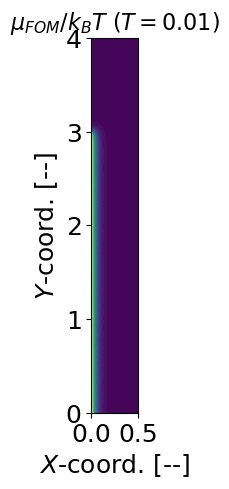

Object cannot be plotted directly, projecting to piecewise linears.


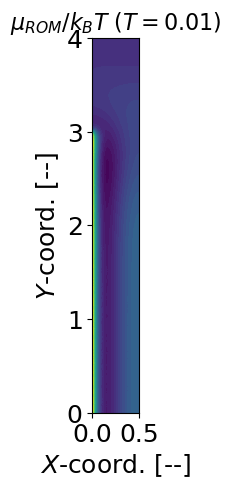

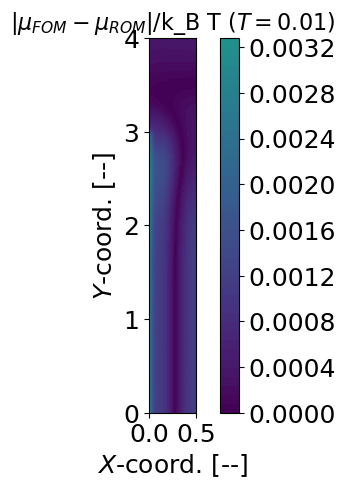

Object cannot be plotted directly, projecting to piecewise linears.


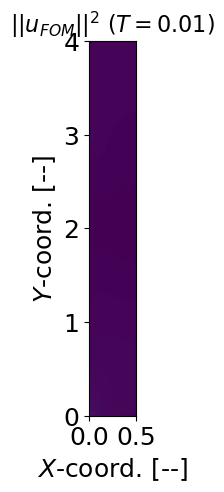

Object cannot be plotted directly, projecting to piecewise linears.


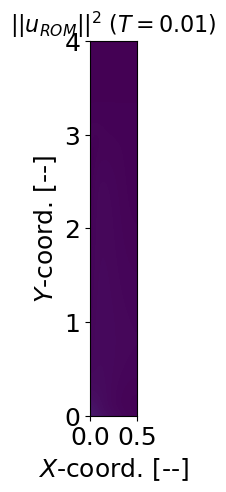

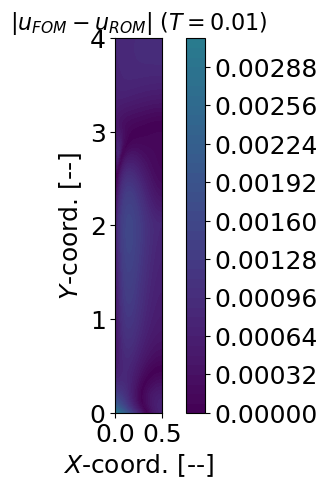

Increment 3
Solving linear variational problem.
Increment 4
Solving linear variational problem.
Increment 5
Solving linear variational problem.
Increment 6
Solving linear variational problem.
Increment 7
Solving linear variational problem.
Increment 8
Solving linear variational problem.
Increment 9
Solving linear variational problem.
Increment 10
Solving linear variational problem.
Increment 11
Solving linear variational problem.
Increment 12
Solving linear variational problem.
Increment 13
Solving linear variational problem.
Increment 14
Solving linear variational problem.
Increment 15
Solving linear variational problem.
Object cannot be plotted directly, projecting to piecewise linears.


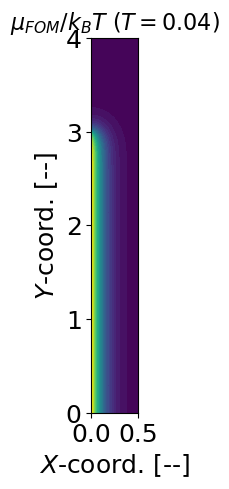

Object cannot be plotted directly, projecting to piecewise linears.


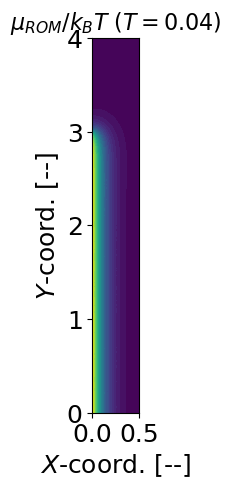

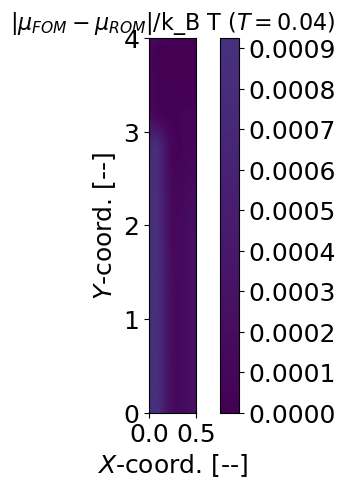

Object cannot be plotted directly, projecting to piecewise linears.


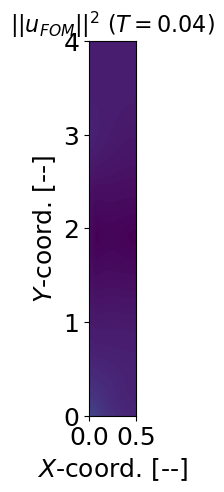

Object cannot be plotted directly, projecting to piecewise linears.


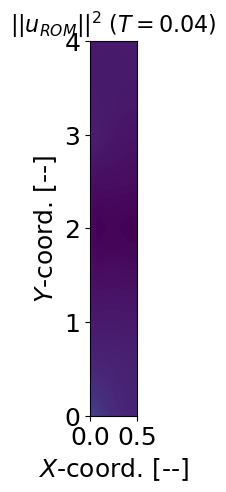

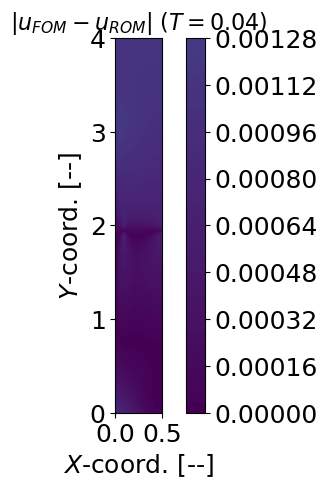

Increment 16
Solving linear variational problem.
Increment 17
Solving linear variational problem.
Increment 18
Solving linear variational problem.
Increment 19
Solving linear variational problem.
Increment 20
Solving linear variational problem.
Increment 21
Solving linear variational problem.
Increment 22
Solving linear variational problem.
Increment 23
Solving linear variational problem.
Increment 24
Solving linear variational problem.
Increment 25
Solving linear variational problem.
Object cannot be plotted directly, projecting to piecewise linears.


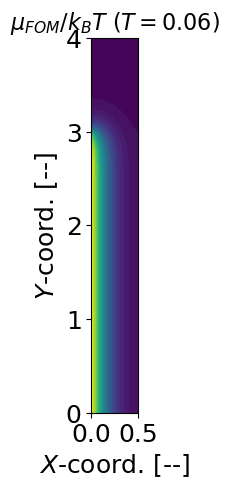

Object cannot be plotted directly, projecting to piecewise linears.


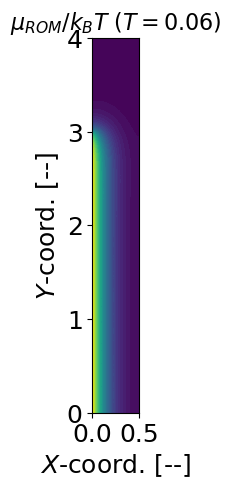

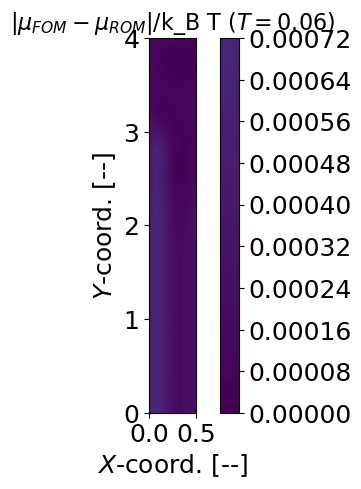

Object cannot be plotted directly, projecting to piecewise linears.


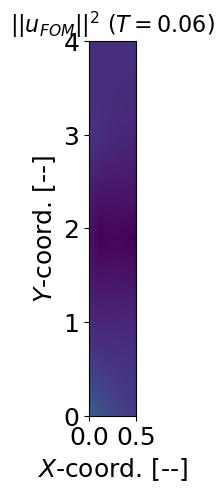

Object cannot be plotted directly, projecting to piecewise linears.


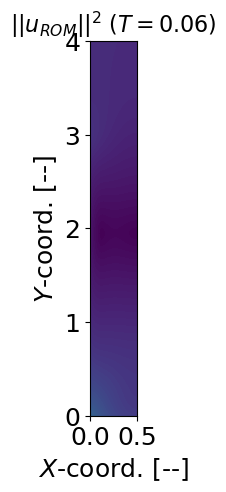

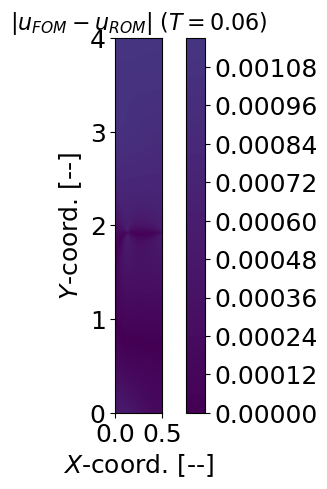

Increment 26
Solving linear variational problem.
Increment 27
Solving linear variational problem.
Increment 28
Solving linear variational problem.
Increment 29
Solving linear variational problem.
Increment 30
Solving linear variational problem.
Increment 31
Solving linear variational problem.
Increment 32
Solving linear variational problem.
Increment 33
Solving linear variational problem.
Increment 34
Solving linear variational problem.
Increment 35
Solving linear variational problem.
Increment 36
Solving linear variational problem.
Increment 37
Solving linear variational problem.
Increment 38
Solving linear variational problem.
Increment 39
Solving linear variational problem.
Increment 40
Solving linear variational problem.
Increment 41
Solving linear variational problem.
Increment 42
Solving linear variational problem.
Increment 43
Solving linear variational problem.
Increment 44
Solving linear variational problem.
Increment 45
Solving linear variational problem.
Increment 46
Solving

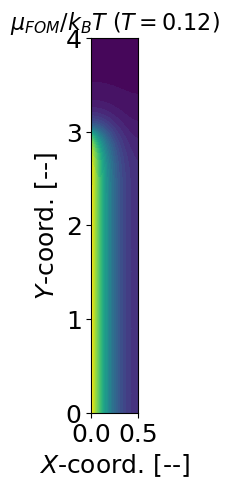

Object cannot be plotted directly, projecting to piecewise linears.


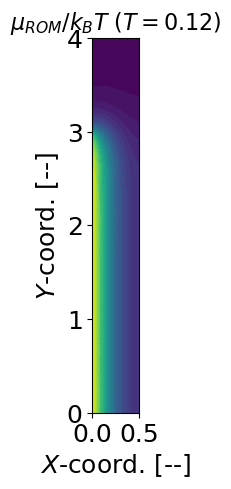

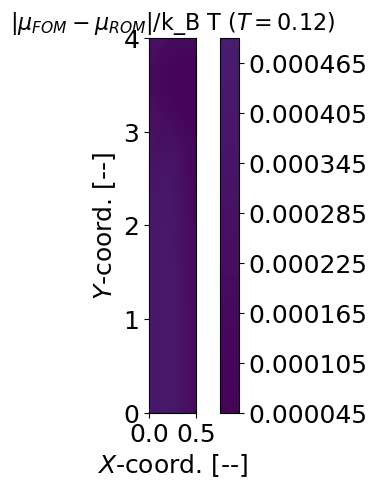

Object cannot be plotted directly, projecting to piecewise linears.


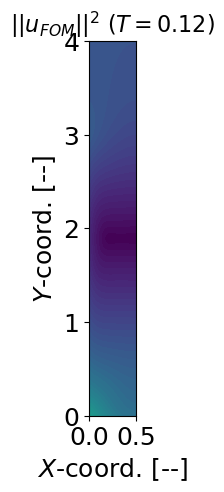

Object cannot be plotted directly, projecting to piecewise linears.


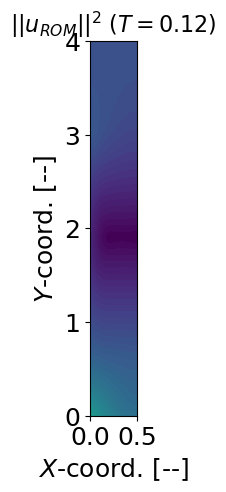

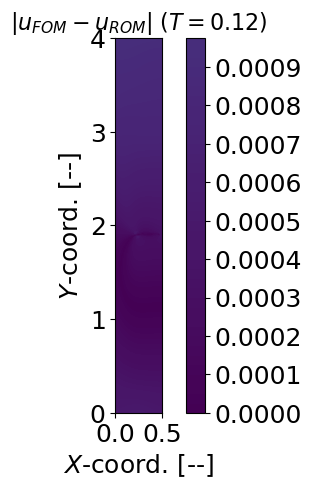

Increment 51
Solving linear variational problem.
Increment 52
Solving linear variational problem.
Increment 53
Solving linear variational problem.
Increment 54
Solving linear variational problem.
Increment 55
Solving linear variational problem.
Increment 56
Solving linear variational problem.
Increment 57
Solving linear variational problem.
Increment 58
Solving linear variational problem.
Increment 59
Solving linear variational problem.
Increment 60
Solving linear variational problem.
Increment 61
Solving linear variational problem.
Increment 62
Solving linear variational problem.
Increment 63
Solving linear variational problem.
Increment 64
Solving linear variational problem.
Increment 65
Solving linear variational problem.
Increment 66
Solving linear variational problem.
Increment 67
Solving linear variational problem.
Increment 68
Solving linear variational problem.
Increment 69
Solving linear variational problem.
Increment 70
Solving linear variational problem.
Increment 71
Solving

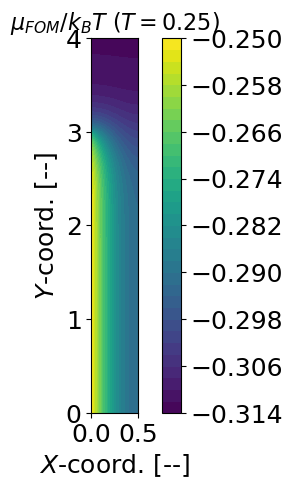

Object cannot be plotted directly, projecting to piecewise linears.


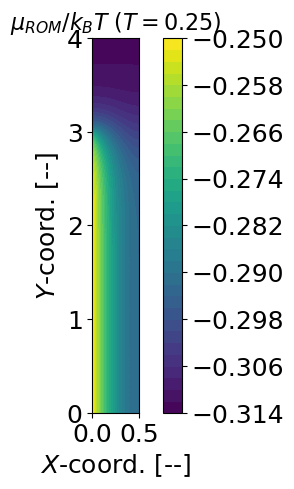

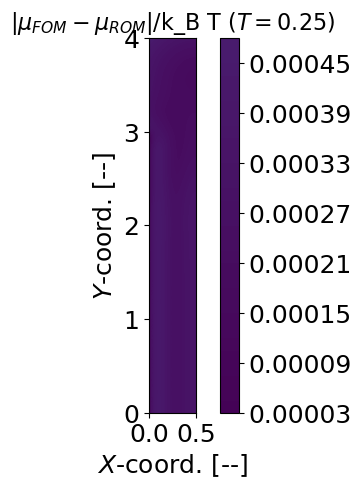

Object cannot be plotted directly, projecting to piecewise linears.


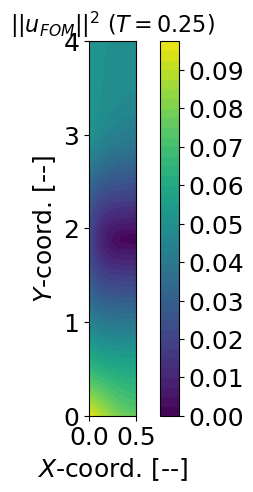

Object cannot be plotted directly, projecting to piecewise linears.


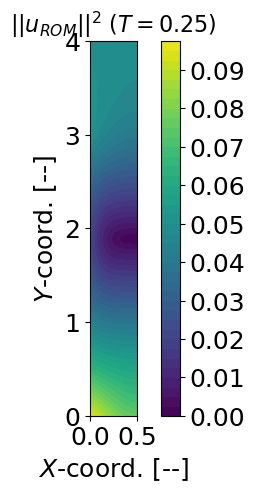

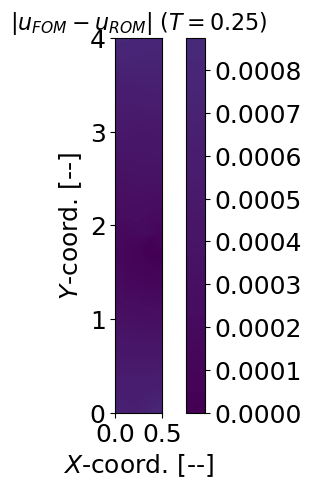

In [12]:
# Form compiler options
parameters["form_compiler"]["optimize"]     = True
parameters["form_compiler"]["cpp_optimize"] = True

# New model setup with halved domain in the x-direction
L = 1  # Thickness of the plate
N = 100  # Mesh density
domain = Rectangle(Point(0., 0.), Point(0.5*L, 4*L))  # Halved domain dimensions in x-direction
mesh = generate_mesh(domain, N)
n = FacetNormal(mesh)

# Define boundary conditions
class Left1(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0) and x[1] > 0.25*(4*L)

class Left2(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0) and x[1] <= 0.75*(4*L)

class RightSymmetry(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.5*L)

class Top(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 4*L)

class Bottom(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 0)

# Add boundaries
left1 = Left1()
left2 = Left2()
right_symmetry = RightSymmetry()
top = Top()
bottom = Bottom()

subdomains = MeshFunction("size_t", mesh, mesh.topology().dim(), 0)
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)
left1.mark(boundaries, 1)
left2.mark(boundaries, 2)
right_symmetry.mark(boundaries, 3)
top.mark(boundaries, 4)
bottom.mark(boundaries, 5)

### Field variable function spaces
element_u = VectorElement('CG', mesh.ufl_cell(), 2) # displacement finite element
element_µ = FiniteElement('CG', mesh.ufl_cell(), 1) # chemical potential finite element
V = FunctionSpace(mesh, MixedElement([element_u, element_µ]))

# Parameters Normalised
µ_init = -0.3124 # initial chemical potential
A = 4000
lmbda = 1558
alpha = 0.66 # robin bcs

# zero displacement boundary conditions on the symmetric part of the plate
u_bc_bottom = DirichletBC(V.sub(0).sub(1), Constant(0.0), bottom) 
µ_swell = -0.001
# bcs = [u_bc_bottom]
bcs = [DirichletBC(V.sub(0).sub(0), Constant(0.0), right_symmetry)] 
# bcs = []

# Class representing the intial conditions
class InitialConditions(UserExpression):
    def eval(self, values, x):
        values[0] = 0.0                 # ux
        values[1] = 0.0                 # uy
        values[2] = µ_init #-0.3124        # mu
    def value_shape(self):
        return (3,)
    
    
dU = TrialFunction(V)
(du, dµ) = split(dU)
V_ = TestFunction(V)
(v, q) = split(V_)
Uold = Function(V)
(uold, µold) = split(Uold)
U = Function(V)
(u, µ) = split(U)

# Create intial conditions and interpolate
u_init = InitialConditions()
Uold.interpolate(u_init)

# Strain
def eps(u):
    return sym( grad(u) )
# Stress 
def sigma(u, µ):
    return 2*eps(u) + ( lmbda*tr(eps(u)) - A*(µ-µ_init) )*Identity(mesh.topology().dim())

dt = Constant(0.)
ds = Measure('ds', subdomain_data=boundaries)

mech_form = inner( sigma(du, dµ),eps(v))*dx
chem_form = (( tr( eps(du)-eps(uold) )/dt )*q*dx + dot(grad(dµ),grad(q))*dx 
            #  + Constant(alpha)*(dµ-µ_swell)*q*ds(1) + Constant(alpha)*(dµ-µ_swell)*q*ds(2)) 
             + Constant(alpha)*(dµ-µ_swell)*q*ds(2)) #+ Constant(alpha)*(dµ-µ_swell)*q*ds(6))
form = mech_form + chem_form

import os

# Define the directory to save the figures
save_dir = "results/ROM/bar/time/"  # Replace with your desired path

# Check if the directory exists, if not, create it
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
# Define fixed color scale range
import matplotlib.colors as mcolors
vmin = 0.0
vmax = 0.1
cbar_ticks = np.linspace(vmin, vmax, num=5)
# Create a Normalize object for the color scale
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

S = U.function_space()
# FOM results
uFOM_time = []
uFOM_25 = []
uFOM_15 = []
uFOM_02 = []
uFOMx_time = []
uFOMy_time = []
µFOM_time = []
# ROM results as per reduced basis functions
uROM_time_10, uROM_time_8, uROM_time_6, uROM_time_4, uROM_time_2 = [], [], [],[],[]
uROMx_time_10, uROMx_time_8, uROMx_time_6, uROMx_time_4, uROMx_time_2 = [], [], [],[],[]
uROMy_time_10, uROMy_time_8, uROMy_time_6, uROMy_time_4, uROMy_time_2 = [], [], [],[],[]
µROM_time_10, µROM_time_8, µROM_time_6, µROM_time_4, µROM_time_2 = [], [], [],[],[]

Nincr = 100
t = np.linspace(0, 0.25, Nincr+1)
Nx = 100
x = np.linspace(0, L, Nx)

for (i, dti) in enumerate(np.diff(t)):
    print("Increment " + str(i+1))
    t_current = t[i+1]
    dt.assign(dti)
    solve(lhs(form) == rhs(form), U, bcs)
    Uold.assign(U)
    (u, µ) = split(U)
    
    # u is stored at each time step
    uFOM_time.append(project(u, S.sub(0).collapse()))
    uFOMx_time.append(project(u[0], S.sub(1).collapse()))
    uFOMy_time.append(project(u[1], S.sub(1).collapse()))
    µFOM_time.append(project(µ,S.sub(1).collapse()))
    
    if i == 1:
        uFOM_02.append(u)
    elif i == 14:
        uFOM_15.append(u)
    elif i == 24:
        uFOM_25.append(u)
    
    # ROM: Solve the reduced problem at this time step
    time_instance = i
    # ROM for 10 RBS func
    reduced_solution_at_time_instance = reduced_solution[time_instance]
    reconstructed_reduced_solution_at_time_instance = reduced_problem.basis_functions[:reduced_solution_at_time_instance.N] * reduced_solution_at_time_instance
    (u_time, µ_time) = split(reconstructed_reduced_solution_at_time_instance)
    
    uROM_time_10.append(u_time)
    uROMx_time_10.append(project(u_time[0], S.sub(1).collapse()))
    uROMy_time_10.append(project(u_time[1], S.sub(1).collapse()))
    µROM_time_10.append(project(µ_time,S.sub(1).collapse()))
    
    # ROM for 8 RBs func
    reduced_solution_at_time_instance = reduced_solution[time_instance]
    reconstructed_reduced_solution_at_time_instance = reduced_problem.basis_functions[:8] * reduced_solution_at_time_instance
    (u_time, µ_time) = split(reconstructed_reduced_solution_at_time_instance)
    
    uROM_time_8.append(u_time)
    uROMx_time_8.append(project(u_time[0], S.sub(1).collapse()))
    uROMy_time_8.append(project(u_time[1], S.sub(1).collapse()))
    µROM_time_8.append(project(µ_time,S.sub(1).collapse()))
    
    # ROM for 6 RBs func
    reduced_solution_at_time_instance = reduced_solution[time_instance]
    reconstructed_reduced_solution_at_time_instance = reduced_problem.basis_functions[:6] * reduced_solution_at_time_instance
    (u_time_6, µ_time_6) = split(reconstructed_reduced_solution_at_time_instance)
    
    uROM_time_6.append(u_time_6)
    uROMx_time_6.append(project(u_time[0], S.sub(1).collapse()))
    uROMy_time_6.append(project(u_time[1], S.sub(1).collapse()))
    µROM_time_6.append(project(µ_time_6,S.sub(1).collapse()))
    
    # ROM for 4 RBs func
    reduced_solution_at_time_instance = reduced_solution[time_instance]
    reconstructed_reduced_solution_at_time_instance = reduced_problem.basis_functions[:4] * reduced_solution_at_time_instance
    (u_time, µ_time) = split(reconstructed_reduced_solution_at_time_instance)
    
    uROM_time_4.append(u_time)
    uROMx_time_4.append(project(u_time[0], S.sub(1).collapse()))
    uROMy_time_4.append(project(u_time[1], S.sub(1).collapse()))
    µROM_time_4.append(project(µ_time,S.sub(1).collapse()))
    
    # ROM for 2 RBs func
    reduced_solution_at_time_instance = reduced_solution[time_instance]
    reconstructed_reduced_solution_at_time_instance = reduced_problem.basis_functions[:2] * reduced_solution_at_time_instance
    (u_time, µ_time) = split(reconstructed_reduced_solution_at_time_instance)
    
    uROM_time_2.append(u_time)
    uROMx_time_2.append(project(u_time[0], S.sub(1).collapse()))
    uROMy_time_2.append(project(u_time[1], S.sub(1).collapse()))
    µROM_time_2.append(project(µ_time,S.sub(1).collapse()))
    
    # Plot every N iterations
    if i == 1 or i == 14 or i == 24 or i == 49 or i == 99: #(i+1) % 20 == 0:
        # Plotting with a fixed color scale
        plt.figure(figsize=(6,5))
        p = plot(µ, title="$\mu$ at time {}".format(i+1))
        plt.xlim((0, 0.5*L))
        plt.ylim((0, 4*L))
        
        if i == 99:
            # Create colorbar with manually defined ticks
            cbar = plt.colorbar(p, extend='both')
            # cbar_ticks = np.linspace(vmin, vmax, 6)
            # cbar.set_ticks(cbar_ticks)
            # cbar.set_ticklabels(["{:.2f}".format(tick) for tick in cbar_ticks])
            cbar.ax.tick_params(labelsize=18)
        
        # plt.axvline(x = 0.5, color = 'k', linestyle = '--', label = 'axvline - full height')
        # plot(mesh, linewidth=1.0)
        plt.tick_params(axis='both', labelsize=18)
        plt.xlabel("$X$-coord. [--]", fontsize=18)
        plt.ylabel("$Y$-coord. [--]", fontsize=18)
        plt.title(r"$\mu_{{FOM}}/k_B T$ ($T = {:.2f}$)".format(t_current), fontsize=16)
        
        # Adjust the margins
        plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.9)
        
        # Save the figure as a PDF in the specified directory
        fig_name = f"chemPotential_FOM_{i+1}_bar_nestedPOD.pdf"
        plt.savefig(os.path.join(save_dir, fig_name), format='pdf')

        # Close the figure to avoid displaying it
        plt.show()
        
        plt.figure(figsize=(6,5))
        p = plot(µ_time_6, title="$\mu$ at time {}".format(i+1))
        plt.xlim((0, 0.5*L))
        plt.ylim((0, 4*L))
        
        if i == 99:
            # Create colorbar with manually defined ticks
            cbar = plt.colorbar(p, extend='both')
            # cbar_ticks = np.linspace(vmin, vmax, 6)
            # cbar.set_ticks(cbar_ticks)
            # cbar.set_ticklabels(["{:.2f}".format(tick) for tick in cbar_ticks])
            cbar.ax.tick_params(labelsize=18)
        
        # plt.axvline(x = 0.5, color = 'k', linestyle = '--', label = 'axvline - full height')
        # plot(mesh, linewidth=1.0)
        plt.tick_params(axis='both', labelsize=18)
        plt.xlabel("$X$-coord. [--]", fontsize=18)
        plt.ylabel("$Y$-coord. [--]", fontsize=18)
        plt.title(r"$\mu_{{ROM}}/k_B T$ ($T = {:.2f}$)".format(t_current), fontsize=16)
        
        # Adjust the margins
        plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.9)
        
        # Save the figure as a PDF in the specified directory
        fig_name = f"chemPotential_ROM_{i+1}_bar_nestedPOD.pdf"
        plt.savefig(os.path.join(save_dir, fig_name), format='pdf')

        # Close the figure to avoid displaying it
        plt.show()
        
        plt.figure(figsize=(6,5))
        # Create functions for the µ components
        µ_full_func = Function(S.sub(1).collapse())
        µ_reduced_func = project(µ_time_6, S.sub(1).collapse())
        
        # Assign the components to these functions
        assign(µ_full_func, U.sub(1))

        # Compute the error for the µ component
        error_µ = Function(S.sub(1).collapse())
        error_µ.vector()[:] = abs(µ_full_func.vector()[:] - µ_reduced_func.vector()[:])
        p = plot(error_µ, title=r"error $\vert \mu_{{FOM}} - \mu_{{ROM}} \vert$ at time {}".format(i+1), 
                vmin=0.0, vmax=0.0065)

        # error_µ = errornorm(µ_full_func, µ_reduced_func, norm_type='L2')
        # p = plot(project(error_µ,S.sub(1).collapse()), title="$\mu$ at time {}".format(i+1))
        plt.xlim((0, 0.5*L))
        plt.ylim((0, 4*L))
        
        # if i == 24:
        #     # Create colorbar with manually defined ticks
        #     cbar = plt.colorbar(p, extend='both')
        #     cbar_ticks = np.linspace(0.0, 0.005, 6)
        #     # cbar.set_ticks(cbar_ticks)
        #     # cbar.set_ticklabels(["{:.2f}".format(tick) for tick in cbar_ticks])
        #     cbar.ax.tick_params(labelsize=18)
        
        # Create colorbar with manually defined ticks
        cbar = plt.colorbar(p, extend='both')
        # cbar_ticks = np.linspace(vmin, vmax, 6)
        # cbar.set_ticks(cbar_ticks)
        # cbar.set_ticklabels(["{:.2f}".format(tick) for tick in cbar_ticks])
        cbar.ax.tick_params(labelsize=18)
    
        # plt.axvline(x = 0.5, color = 'k', linestyle = '--', label = 'axvline - full height')
        # plot(mesh, linewidth=1.0)
        plt.tick_params(axis='both', labelsize=18)
        plt.xlabel("$X$-coord. [--]", fontsize=18)
        plt.ylabel("$Y$-coord. [--]", fontsize=18)
        plt.title(r"$\vert \mu_{{FOM}} - \mu_{{ROM}} \vert$/k_B T ($T = {:.2f}$)".format(t_current), fontsize=16)
        
        # Adjust the margins
        plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.9)
        
        # Save the figure as a PDF in the specified directory
        fig_name = f"chemPotential_error_{i+1}_bar_nestedPOD.pdf"
        plt.savefig(os.path.join(save_dir, fig_name), format='pdf')

        # Close the figure to avoid displaying it
        plt.show()
                
        # Plotting with a fixed color scale
        plt.figure(figsize=(6,5))
        displacement_magnitude = sqrt(inner(u,u))
        p = plot(displacement_magnitude, title="$u$ at time {}".format(i+1), 
                vmin=vmin, vmax=vmax)
        plt.xlim((0, 0.5*L))
        plt.ylim((0, 4*L))
        
        if i == 99:
            # Create colorbar with manually defined ticks
            cbar = plt.colorbar(p, extend='both')
            # cbar_ticks = np.linspace(vmin, vmax, 6)
            # cbar.set_ticks(cbar_ticks)
            # cbar.set_ticklabels(["{:.2f}".format(tick) for tick in cbar_ticks])
            cbar.ax.tick_params(labelsize=18)
        
        # plt.axvline(x = 0.5, color = 'k', linestyle = '--', label = 'axvline - full height')
        # plot(mesh, linewidth=1.0)
        plt.tick_params(axis='both', labelsize=18)
        plt.xlabel("$X$-coord. [--]", fontsize=18)
        plt.ylabel("$Y$-coord. [--]", fontsize=18)
        plt.title(r"$\vert\vert u_{{FOM}} \vert\vert^2$ ($T = {:.2f}$)".format(t_current), fontsize = 16)
        
        # Adjust the margins
        plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.9)
        
        # Save the figure as a PDF in the specified directory
        fig_name = f"dispField_FOM_{i+1}_bar_nestedPOD.pdf"
        plt.savefig(os.path.join(save_dir, fig_name), format='pdf')

        # Close the figure to avoid displaying it
        plt.show()
        
        # Plotting with a fixed color scale
        plt.figure(figsize=(6,5))
        displacement_magnitude_MOR = sqrt(inner(u_time_6,u_time_6))
        p = plot(displacement_magnitude_MOR, title="$u$ at time {}".format(i+1), 
                vmin=vmin, vmax=vmax)
        plt.xlim((0, 0.5*L))
        plt.ylim((0, 4*L))
        
        if i == 99:
            # Create colorbar with manually defined ticks
            cbar = plt.colorbar(p, extend='both')
            # cbar_ticks = np.linspace(vmin, vmax, 6)
            # cbar.set_ticks(cbar_ticks)
            # cbar.set_ticklabels(["{:.2f}".format(tick) for tick in cbar_ticks])
            cbar.ax.tick_params(labelsize=18)
        
        # plt.axvline(x = 0.5, color = 'k', linestyle = '--', label = 'axvline - full height')
        # plot(mesh, linewidth=1.0)
        plt.tick_params(axis='both', labelsize=18)
        plt.xlabel("$X$-coord. [--]", fontsize=18)
        plt.ylabel("$Y$-coord. [--]", fontsize=18)
        plt.title(r"$\vert\vert u_{{ROM}} \vert\vert^2$ ($T = {:.2f}$)".format(t_current), fontsize = 16)
        
        # Adjust the margins
        plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.9)
        
        # Save the figure as a PDF in the specified directory
        fig_name = f"dispField_ROM_{i+1}_bar_nestedPOD.pdf"
        plt.savefig(os.path.join(save_dir, fig_name), format='pdf')

        # Close the figure to avoid displaying it
        plt.show()
        
        plt.figure(figsize=(6,5))
        # Create functions for the µ components
        dips_mag_FOM = project(displacement_magnitude,S.sub(1).collapse())
        dips_mag_MOR = project(displacement_magnitude_MOR,S.sub(1).collapse())
        # print(len(dips_mag_FOM.vector()[:]))
        # print(len(dips_mag_MOR.vector()[:]))
        # print(dips_mag_FOM.vector()[:] - dips_mag_MOR.vector()[:])
        error_u = Function(S.sub(1).collapse())
        error_u.vector()[:] = abs(dips_mag_FOM.vector()[:] - dips_mag_MOR.vector()[:])
        p = plot(error_u, title=r"error $\vert u_{{FOM}} - u_{{ROM}} \vert$ at time {}".format(i+1), 
                vmin=0.0, vmax=0.0075)

        # error_µ = errornorm(µ_full_func, µ_reduced_func, norm_type='L2')
        # p = plot(project(error_µ,S.sub(1).collapse()), title="$\mu$ at time {}".format(i+1))
        plt.xlim((0, 0.5*L))
        plt.ylim((0, 4*L))
        
        # if i == 24:
        #     # Create colorbar with manually defined ticks
        #     cbar = plt.colorbar(p, extend='both')
        #     cbar_ticks = np.linspace(0.0, 0.003, 6)
        #     # cbar.set_ticks(cbar_ticks)
        #     # cbar.set_ticklabels(["{:.2f}".format(tick) for tick in cbar_ticks])
        #     cbar.ax.tick_params(labelsize=18)
        
        # Create colorbar with manually defined ticks
        cbar = plt.colorbar(p, extend='both')
        # cbar_ticks = np.linspace(vmin, vmax, 6)
        # cbar.set_ticks(cbar_ticks)
        # cbar.set_ticklabels(["{:.2f}".format(tick) for tick in cbar_ticks])
        cbar.ax.tick_params(labelsize=18)
    
        # plt.axvline(x = 0.5, color = 'k', linestyle = '--', label = 'axvline - full height')
        # plot(mesh, linewidth=1.0)
        plt.tick_params(axis='both', labelsize=18)
        plt.xlabel("$X$-coord. [--]", fontsize=18)
        plt.ylabel("$Y$-coord. [--]", fontsize=18)
        plt.title(r"$\vert u_{{FOM}} - u_{{ROM}} \vert$ ($T = {:.2f}$)".format(t_current), fontsize=16)
        
        # Adjust the margins
        plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.9)
        
        # Save the figure as a PDF in the specified directory
        fig_name = f"dispField_error_{i+1}_bar_nestedPOD.pdf"
        plt.savefig(os.path.join(save_dir, fig_name), format='pdf')

        # Close the figure to avoid displaying it
        plt.show()

In [13]:
# Error plot
# Initialize arrays to store displacement values for each point
uFOMx_00 = np.zeros(Nincr)
uFOMx_052 = np.zeros(Nincr)
uFOMx_14 = np.zeros(Nincr)
uFOMx_12 = np.zeros(Nincr)

uROMx_00 = np.zeros((5,Nincr))
uROMx_052 = np.zeros((5,Nincr))
uROMx_14 = np.zeros((5,Nincr))
uROMx_12 = np.zeros((5,Nincr))
    
    
for i in range(Nincr):
    uFOMx_00[i] = uFOMx_time[i](0, 0)
    uFOMx_052[i] = uFOMx_time[i](0.5, 0)
    uFOMx_14[i] = uFOMx_time[i](0.25, 4)
    uFOMx_12[i] = uFOMx_time[i](0.25, 2)
    
    uROMx_00[0,i], uROMx_00[1,i], uROMx_00[2,i], uROMx_00[3,i], uROMx_00[4,i] = uROMx_time_2[i](0, 0), uROMx_time_4[i](0, 0), uROMx_time_6[i](0, 0), uROMx_time_8[i](0, 0), uROMx_time_10[i](0, 0)
    uROMx_052[0,i], uROMx_052[1,i], uROMx_052[2,i], uROMx_052[3,i], uROMx_052[4,i] = uROMx_time_2[i](0.5, 0), uROMx_time_4[i](0.5, 0), uROMx_time_6[i](0.5, 0), uROMx_time_8[i](0.5, 0), uROMx_time_10[i](0.5, 0)
    uROMx_14[0,i], uROMx_14[1,i], uROMx_14[2,i], uROMx_14[3,i], uROMx_14[4,i] = uROMx_time_2[i](0.25, 4), uROMx_time_4[i](0.25, 4), uROMx_time_6[i](0.25, 4), uROMx_time_8[i](0.25, 4), uROMx_time_10[i](0.25, 4)
    uROMx_12[0,i], uROMx_12[1,i], uROMx_12[2,i], uROMx_12[3,i], uROMx_12[4,i] = uROMx_time_2[i](0.25, 2), uROMx_time_4[i](0.25, 2), uROMx_time_6[i](0.25, 2), uROMx_time_8[i](0.25, 2), uROMx_time_10[i](0.25, 2)

In [14]:
# Error plot
# Initialize arrays to store chemical potential values for each point
µFOM_00 = np.zeros(Nincr)
µFOM_052 = np.zeros(Nincr)
µFOM_14 = np.zeros(Nincr)
µFOM_12 = np.zeros(Nincr)

µROM_00 = np.zeros((5,Nincr))
µROM_052 = np.zeros((5,Nincr))
µROM_14 = np.zeros((5,Nincr))
µROM_12 = np.zeros((5,Nincr))
    
    
for i in range(Nincr):
    µFOM_00[i] = µFOM_time[i](0, 0)
    µFOM_052[i] = µFOM_time[i](0.5, 0)
    µFOM_14[i] = µFOM_time[i](0.25, 4)
    µFOM_12[i] = µFOM_time[i](0.25, 2)
    
    µROM_00[0,i], µROM_00[1,i], µROM_00[2,i], µROM_00[3,i], µROM_00[4,i] = µROM_time_2[i](0, 0), µROM_time_4[i](0, 0), µROM_time_6[i](0, 0), µROM_time_8[i](0, 0), µROM_time_10[i](0, 0)
    µROM_052[0,i], µROM_052[1,i], µROM_052[2,i], µROM_052[3,i], µROM_052[4,i] = µROM_time_2[i](0.5, 0), µROM_time_4[i](0.5, 0), µROM_time_6[i](0.5, 0), µROM_time_8[i](0.5, 0), µROM_time_10[i](0.5, 0)
    µROM_14[0,i], µROM_14[1,i], µROM_14[2,i], µROM_14[3,i], µROM_14[4,i] = µROM_time_2[i](0.25, 4), µROM_time_4[i](0.25, 4), µROM_time_6[i](0.25, 4), µROM_time_8[i](0.25, 4), µROM_time_10[i](0.25, 4)
    µROM_12[0,i], µROM_12[1,i], µROM_12[2,i], µROM_12[3,i], µROM_12[4,i] = µROM_time_2[i](0.25, 2), µROM_time_4[i](0.25, 2), µROM_time_6[i](0.25, 2), µROM_time_8[i](0.25, 2), µROM_time_10[i](0.25, 2)

/usr/local/lib/python3.8/dist-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D(_line4), but could not find a label for it.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D(_line5), but could not find a label for it.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D(_line6), but could not find a label for it.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D(_line7), but could not find a label for it.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/labellines/core.py:216: UserWarning: The value at position 0 in `xvals` is outside the range of its associated line (xmin=0.002500000000000009, xmax=0.25, xval=0.8). Clipping it into the allowed range.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/labellines/core.py:216: UserWarning: The value 

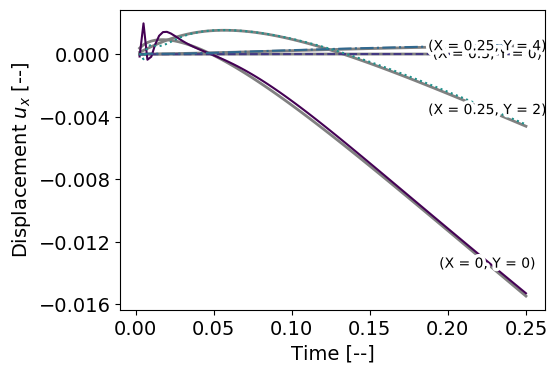

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from labellines import labelLines
from matplotlib.ticker import MaxNLocator

# Setup figure and axis
fig, ax = plt.subplots(figsize=(5,4))

# Define the range of values for normalization
nPoints = 4  # Assuming 5 ROM models
points = np.arange(nPoints)

# Setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=points.min(), vmax=points.max() * 2)  # Limit to half the original range to focus on blue-green
colormap = cm.viridis

# Set the desired line width
line_width = 2

# Define different line styles for each ROM plot
line_styles = ['-', '--', '-.', ':']  # Additional custom dash pattern
custom_labels = ["ROM - 2 basis func.", "ROM - 4 basis func.", "ROM - 6 basis func.", "ROM - 8 basis func.", "ROM - 10 basis func."]

# Plotting FOM data with grey dashed lines
ax.plot(t[1:], uFOMx_00, color='grey', label='(X = 0, Y = 0)', linewidth=line_width)
ax.plot(t[1:], uFOMx_052, color='grey', label='(X = 0.5, Y = 0)', linewidth=line_width)
ax.plot(t[1:], uFOMx_14, color='grey', label='(X = 0.25, Y = 4)', linewidth=line_width)
ax.plot(t[1:], uFOMx_12, color='grey', label='(X = 0.25, Y = 2)', linewidth=line_width)
    
# Customizing labels in the plotting loop
# Assuming custom_labels is a list of strings with custom labels for each point
custom_labels = ["ROM - 2 basis func.", "ROM - 4 basis func.", "ROM - 6 basis func.", "ROM - 8 basis func.", "ROM - 10 basis func."]

ax.plot(t[1:], uROMx_00[3, :], line_styles[0], color=colormap(normalize(points[0])))
ax.plot(t[1:], uROMx_052[3, :], line_styles[1], color=colormap(normalize(points[1])))
ax.plot(t[1:], uROMx_14[3, :], line_styles[2], color=colormap(normalize(points[2])))
ax.plot(t[1:], uROMx_12[3, :], line_styles[3], color=colormap(normalize(points[3])))

# Label lines with xvals for better placement
labelLines([line for line in ax.get_lines() if 'ROM' not in line.get_label()], align=False, zorder=2.5, color="k", fontsize=10, xvals=[0.8 + i for i in range(4)])

# Set labels and other properties
ax.set_xlabel('Time [--]', fontsize=14)
ax.set_ylabel('Displacement $u_x$ [--]', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)

# Set the maximum number of ticks for x and y axes
ax.xaxis.set_major_locator(MaxNLocator(nbins=6))
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))

# Add a legend to help distinguish between ROM models
# ax.legend(loc='upper right', fontsize=10, frameon=True)

plt.tight_layout()
plt.subplots_adjust(left=0.1, bottom=0.15, right=0.95, top=0.9)
plt.savefig('results/ROM/bar/Fig_2DFEM_ux_time_nestedPOD.pdf', bbox_inches='tight')
plt.show()

In [18]:
from scipy.interpolate import UnivariateSpline
import numpy as np

def spline_smooth(data, t, smoothing_factor=5):
    """Apply spline interpolation for smoothing."""
    spline = UnivariateSpline(t, data, s=smoothing_factor)
    return spline(t)

# Assuming t and Nincr are defined
# Assuming uFOMx_00, uFOMx_052, uFOMx_14, and uFOMx_12 are defined
# Initialize the error arrays
u_err00 = np.zeros((5, Nincr))
u_err052 = np.zeros((5, Nincr))
u_err14 = np.zeros((5, Nincr))
u_err12 = np.zeros((5, Nincr))

# Smooth the uFOMx_** data
uFOMx_00_smoothed = spline_smooth(uFOMx_00, t[1:], smoothing_factor=5)
uFOMx_052_smoothed = spline_smooth(uFOMx_052, t[1:], smoothing_factor=5)
uFOMx_14_smoothed = spline_smooth(uFOMx_14, t[1:], smoothing_factor=5)
uFOMx_12_smoothed = spline_smooth(uFOMx_12, t[1:], smoothing_factor=5)

# Compute the error using smoothed data
for i in range(5):
    u_err00[i, :] = np.sqrt((uFOMx_00_smoothed - uROMx_00[i, :])**2)
    u_err052[i, :] = np.sqrt((uFOMx_052_smoothed - uROMx_052[i, :])**2)
    u_err14[i, :] = np.sqrt((uFOMx_14_smoothed - uROMx_14[i, :])**2)
    u_err12[i, :] = np.sqrt((uFOMx_12_smoothed - uROMx_12[i, :])**2)

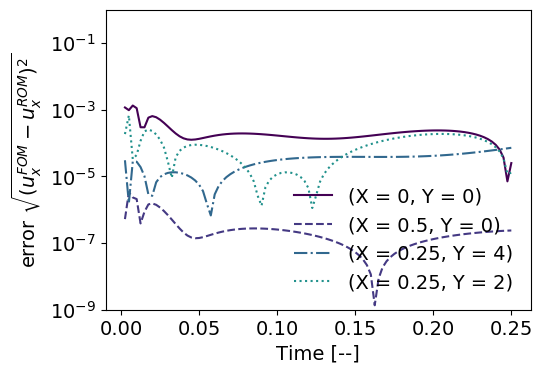

In [49]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.ticker import MaxNLocator
import numpy as np

fig, ax = plt.subplots(figsize=(5,4))

# Define the range of values for normalization and setup the colormap
points = np.arange(4)
normalize = mcolors.Normalize(vmin=points.min(), vmax=points.max()*2)
colormap = cm.viridis

# Define different line styles for each plot for visibility
line_styles = ['-', '--', '-.', ':']  # Additional custom dash pattern

ax.semilogy(t[1:], u_err00[3], line_styles[0], color=colormap(normalize(points[0])), label='(X = 0, Y = 0)')
ax.semilogy(t[1:], u_err052[3], line_styles[1], color=colormap(normalize(points[1])), label='(X = 0.5, Y = 0)')
ax.semilogy(t[1:], u_err14[3], line_styles[2], color=colormap(normalize(points[2])), label='(X = 0.25, Y = 4)')
ax.semilogy(t[1:], u_err12[3], line_styles[3], color=colormap(normalize(points[3])), label='(X = 0.25, Y = 2)')

ylabel = r'error $\sqrt{( u^{{FOM}}_x - u^{{ROM}}_x )^2}$'
# Set labels and other properties
ax.set_xlabel('Time [--]', fontsize=14)
ax.set_ylabel(ylabel, fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.xaxis.set_major_locator(MaxNLocator(nbins=6))

# Label lines with xvals for better placement
# labelLines([line for line in ax.get_lines() if 'ROM' not in line.get_label()], align=False, zorder=2.5, color="k", fontsize=14, xvals=[0.1 + i for i in range(4)])

# Set y-axis limits
ax.set_ylim(1e-9, 1e-0)  # Set y-axis limits

# Set title
# ax.set_title(title, fontsize=16)

# Add a legend if show_legend is True
ax.legend(loc='best', fontsize=14, frameon= False, ncol=1)

plt.tight_layout()
plt.subplots_adjust(left=0.1, bottom=0.15, right=0.95, top=0.9)
file_name = 'results/ROM/bar/Fig_gel_bar_squared_error_ux_time_nestedPOD.pdf'
plt.savefig(file_name, bbox_inches='tight')
plt.show()

In [22]:
# Error plot
# Initialize arrays to store displacement values for each point
uFOMy_00 = np.zeros(Nincr)
uFOMy_052 = np.zeros(Nincr)
uFOMy_14 = np.zeros(Nincr)
uFOMy_12 = np.zeros(Nincr)

uROMy_00 = np.zeros((5,Nincr))
uROMy_052 = np.zeros((5,Nincr))
uROMy_14 = np.zeros((5,Nincr))
uROMy_12 = np.zeros((5,Nincr))
   
for i in range(Nincr):
    uFOMy_00[i] = uFOMy_time[i](0, 0)
    uFOMy_052[i] = uFOMy_time[i](0.5, 0)
    uFOMy_14[i] = uFOMy_time[i](0.25, 4)
    uFOMy_12[i] = uFOMy_time[i](0.25, 2)
    
    uROMy_00[0,i], uROMy_00[1,i], uROMy_00[2,i], uROMy_00[3,i], uROMy_00[4,i] = uROMy_time_2[i](0, 0), uROMy_time_4[i](0, 0), uROMy_time_6[i](0, 0), uROMy_time_8[i](0, 0), uROMy_time_10[i](0, 0)
    uROMy_052[0,i], uROMy_052[1,i], uROMy_052[2,i], uROMy_052[3,i], uROMy_052[4,i] = uROMy_time_2[i](0.5, 0), uROMy_time_4[i](0.5, 0), uROMy_time_6[i](0.5, 0), uROMy_time_8[i](0.5, 0), uROMy_time_10[i](0.5, 0)
    uROMy_14[0,i], uROMy_14[1,i], uROMy_14[2,i], uROMy_14[3,i], uROMy_14[4,i] = uROMy_time_2[i](0.25, 4), uROMy_time_4[i](0.25, 4), uROMy_time_6[i](0.25, 4), uROMy_time_8[i](0.25, 4), uROMy_time_10[i](0.25, 4)
    uROMy_12[0,i], uROMy_12[1,i], uROMy_12[2,i], uROMy_12[3,i], uROMy_12[4,i] = uROMy_time_2[i](0.25, 2), uROMy_time_4[i](0.25, 2), uROMy_time_6[i](0.25, 2), uROMy_time_8[i](0.25, 2), uROMy_time_10[i](0.25, 2)

/usr/local/lib/python3.8/dist-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D(_line4), but could not find a label for it.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D(_line5), but could not find a label for it.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D(_line6), but could not find a label for it.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D(_line7), but could not find a label for it.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/labellines/core.py:216: UserWarning: The value at position 0 in `xvals` is outside the range of its associated line (xmin=0.002500000000000009, xmax=0.25, xval=0.8). Clipping it into the allowed range.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/labellines/core.py:216: UserWarning: The value 

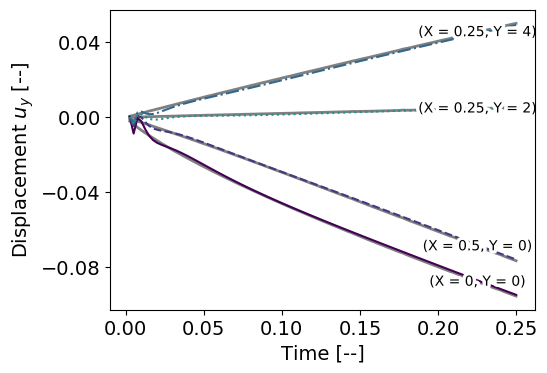

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from labellines import labelLines
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D

# Setup figure and axis
fig, ax = plt.subplots(figsize=(5,4))

# Assuming t, uFOMy_00, uFOMy_052, uFOMy_12, uFOMy_14, uROMy_00, uROMy_052, uROMy_12, and uROMy_14 are defined

# Define the range of values for normalization
nPoints = 4  # Assuming 5 ROM models
points = np.arange(nPoints)

# Setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=points.min(), vmax=points.max()*2)
colormap = cm.viridis

# Set the desired line width
line_width = 2

# Plotting FOM data with increased line width
ax.plot(t[1:], uFOMy_00, color='grey', label='(X = 0, Y = 0)', linewidth=line_width)
ax.plot(t[1:], uFOMy_052, color='grey', label='(X = 0.5, Y = 0)', linewidth=line_width)
ax.plot(t[1:], uFOMy_14, color='grey', label='(X = 0.25, Y = 4)', linewidth=line_width)
ax.plot(t[1:], uFOMy_12, color='grey', label='(X = 0.25, Y = 2)', linewidth=line_width)

# Customizing labels in the plotting loop
custom_labels = ["ROM - 2 basis func.", "ROM - 4 basis func.", "ROM - 6 basis func.", "ROM - 8 basis func.", "ROM - 10 basis func."]

# Define a list of line styles to cycle through
line_styles = ['-', '--', '-.', ':']

# Plotting with custom labels and different line styles for each quantity
ax.plot(t[1:], uROMy_00[3, :], line_styles[0], color=colormap(normalize(points[0])))
ax.plot(t[1:], uROMy_052[3, :], line_styles[1], color=colormap(normalize(points[1])))
ax.plot(t[1:], uROMy_14[3, :], line_styles[2], color=colormap(normalize(points[2])))
ax.plot(t[1:], uROMy_12[3, :], line_styles[3], color=colormap(normalize(points[3])))

# Only label the FOM lines
x_positions_for_labels = [0.8 + i for i in range(len(ax.get_lines()))]
labelLines([line for line in ax.get_lines() if 'ROM' not in line.get_label()], align=False, zorder=2.5, color="k", fontsize=10, xvals=x_positions_for_labels)

# Set labels and other properties
ax.set_xlabel('Time [--]', fontsize=14)
ax.set_ylabel('Displacement $u_y$ [--]', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)

# Set the maximum number of ticks for x and y axes
ax.xaxis.set_major_locator(MaxNLocator(nbins=6))
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))

plt.tight_layout()
plt.subplots_adjust(left=0.1, bottom=0.15, right=0.95, top=0.9)
plt.savefig('results/ROM/bar/Fig_2DFEM_uy_time_nestedPOD.pdf', bbox_inches='tight')
plt.show()

In [24]:
from scipy.interpolate import UnivariateSpline
import numpy as np

def spline_smooth(data, t, smoothing_factor=5):
    """Apply spline interpolation for smoothing."""
    spline = UnivariateSpline(t, data, s=smoothing_factor)
    return spline(t)

# Assuming t and Nincr are defined
# Assuming uFOMy_00, uFOMy_052, uFOMy_14, and uFOMy_12 are defined
# Initialize the error arrays for y-component
u_err00_y = np.zeros((5, Nincr))
u_err052_y = np.zeros((5, Nincr))
u_err14_y = np.zeros((5, Nincr))
u_err12_y = np.zeros((5, Nincr))

# Smooth the uFOMy_** data
uFOMy_00_smoothed = spline_smooth(uFOMy_00, t[1:], smoothing_factor=5)
uFOMy_052_smoothed = spline_smooth(uFOMy_052, t[1:], smoothing_factor=5)
uFOMy_14_smoothed = spline_smooth(uFOMy_14, t[1:], smoothing_factor=5)
uFOMy_12_smoothed = spline_smooth(uFOMy_12, t[1:], smoothing_factor=5)

# Compute the error using smoothed data for y-component
for i in range(5):
    u_err00_y[i, :] = np.sqrt((uFOMy_00_smoothed - uROMy_00[i, :])**2)
    u_err052_y[i, :] = np.sqrt((uFOMy_052_smoothed - uROMy_052[i, :])**2)
    u_err14_y[i, :] = np.sqrt((uFOMy_14_smoothed - uROMy_14[i, :])**2)
    u_err12_y[i, :] = np.sqrt((uFOMy_12_smoothed - uROMy_12[i, :])**2)

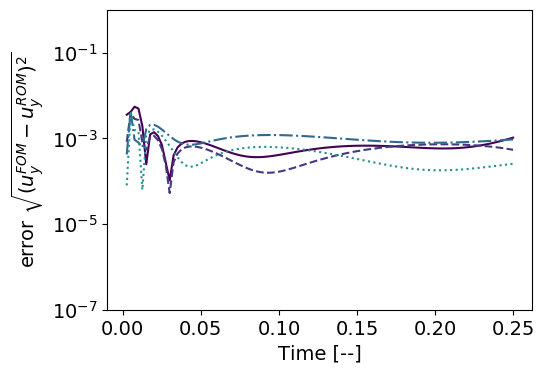

In [25]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.ticker import MaxNLocator
import numpy as np

fig, ax = plt.subplots(figsize=(5,4))

# Define the range of values for normalization and setup the colormap
points = np.arange(4)
normalize = mcolors.Normalize(vmin=points.min(), vmax=points.max()*2)
colormap = cm.viridis

# Define different line styles for each plot for visibility
line_styles = ['-', '--', '-.', ':']  # Additional custom dash pattern

ax.semilogy(t[1:], u_err00_y[3], line_styles[0], color=colormap(normalize(points[0])), label='(X = 0, Y = 0)')
ax.semilogy(t[1:], u_err052_y[3], line_styles[1], color=colormap(normalize(points[1])), label='(X = 0.25, Y = 1)')
ax.semilogy(t[1:], u_err14_y[3], line_styles[2], color=colormap(normalize(points[2])), label='(X = 0, Y = 4)')
ax.semilogy(t[1:], u_err12_y[3], line_styles[3], color=colormap(normalize(points[3])), label='(X = 0.25, Y = 3)')

ylabel = r'error $\sqrt{( u^{{FOM}}_y - u^{{ROM}}_y )^2}$'
# Set labels and other properties
ax.set_xlabel('Time [--]', fontsize=14)
ax.set_ylabel(ylabel, fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.xaxis.set_major_locator(MaxNLocator(nbins=6))

# Label lines with xvals for better placement
# labelLines([line for line in ax.get_lines() if 'ROM' not in line.get_label()], align=False, zorder=2.5, color="k", fontsize=14, xvals=[0.1 + i for i in range(4)])

# Set y-axis limits
ax.set_ylim(1e-7, 1e-0)  # Set y-axis limits

# Set title
# ax.set_title(title, fontsize=16)

# Add a legend if show_legend is True
# ax.legend(loc='best', fontsize=14, frameon= False, ncol=1)

plt.tight_layout()
plt.subplots_adjust(left=0.1, bottom=0.15, right=0.95, top=0.9)
file_name = 'results/ROM/bar/Fig_gel_bar_squared_error_uy_time_nestedPOD.pdf'
plt.savefig(file_name, bbox_inches='tight')
plt.show()

/usr/local/lib/python3.8/dist-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D(_line4), but could not find a label for it.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D(_line5), but could not find a label for it.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D(_line6), but could not find a label for it.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D(_line7), but could not find a label for it.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/labellines/core.py:216: UserWarning: The value at position 0 in `xvals` is outside the range of its associated line (xmin=0.002500000000000009, xmax=0.25, xval=0.8). Clipping it into the allowed range.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/labellines/core.py:216: UserWarning: The value 

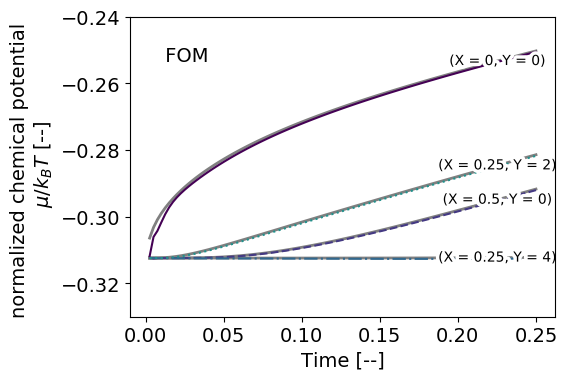

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from labellines import labelLines
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D

# Setup figure and axis
fig, ax = plt.subplots(figsize=(5,4))

# Assuming t, uFOMx_00, uFOMx_052, uFOMx_12, uFOMx_14, uROMx_00, uROMx_052, uROMx_12, and uROMx_14 are defined

# Define the range of values for normalization
nPoints = 4  # Assuming 5 ROM models
points = np.arange(nPoints)

# Setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=points.min(), vmax=points.max()*2)
colormap = cm.viridis

# Set the desired line width
line_width = 2

# Plotting FOM data with increased line width
ax.plot(t[1:], µFOM_00, color='grey', label='(X = 0, Y = 0)', linewidth=line_width)
ax.plot(t[1:], µFOM_052, color='grey', label='(X = 0.5, Y = 0)', linewidth=line_width)
ax.plot(t[1:], µFOM_14, color='grey', label='(X = 0.25, Y = 4)', linewidth=line_width)
ax.plot(t[1:], µFOM_12, color='grey', label='(X = 0.25, Y = 2)', linewidth=line_width)
    
# Customizing labels in the plotting loop
# Assuming custom_labels is a list of strings with custom labels for each point
custom_labels = ["ROM - 2 basis func.", "ROM - 4 basis func.", "ROM - 6 basis func.", "ROM - 8 basis func.", "ROM - 10 basis func."]

# Assuming the setup and imports are already done

# Define different line styles for each plot for visibility
line_styles = ['-', '--', '-.', ':']  # Adding a custom dash pattern

ax.plot(t[1:], µROM_00[3, :], line_styles[0], color=colormap(normalize(points[0])))
ax.plot(t[1:], µROM_052[3, :], line_styles[1], color=colormap(normalize(points[1])))
ax.plot(t[1:], µROM_14[3, :], line_styles[2], color=colormap(normalize(points[2])))
ax.plot(t[1:], µROM_12[3, :], line_styles[3], color=colormap(normalize(points[3])))

# Only label the FOM lines
x_positions_for_labels = [0.8 + i for i in range(len(ax.get_lines()))]
labelLines([line for line in ax.get_lines() if 'ROM' not in line.get_label()], align=False, zorder=2.5, color="k", fontsize=10, xvals=x_positions_for_labels)

# Custom text box with lines
# text_str = "      ROM\n      FOM"
text_str = "         \n          FOM"
text_box = ax.text(0.183, 0.975, text_str, transform=ax.transAxes, fontsize=14,
                   verticalalignment='top', horizontalalignment='right')

# Draw small line segments within the text box
tbox = text_box.get_window_extent(renderer=fig.canvas.get_renderer())
x0, y0 = ax.transAxes.inverted().transform((tbox.x0, tbox.y0))
x1, y1 = ax.transAxes.inverted().transform((tbox.x1, tbox.y1))
line_height = (y1 - y0) / 3

# # Solid line
# ax.add_line(Line2D([x0 + 0.01, x0 + 0.05], [y1 - line_height, y1 - line_height], 
#                    color='black', transform=ax.transAxes, linestyle='solid'))


# Dashed line
ax.add_line(Line2D([x0 + 0.01, x0 + 0.075], [y1 - 2 * line_height, y1 - 2 * line_height], 
                   color='black', transform=ax.transAxes, linestyle='solid'))

# Set labels and other properties
ax.set_xlabel('Time [--]', fontsize=14)
ax.set_ylabel('normalized chemical potential \n $\mu/k_B T$ [--]', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)

ax.set_ylim(-0.33, -0.24)

# Set the maximum number of ticks for x and y axes
ax.xaxis.set_major_locator(MaxNLocator(nbins=6))
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))

# Add a legend to display the ROM labels
lines, labels = ax.get_legend_handles_labels()
unique_labels = []
unique_lines = []
for line, label in zip(lines, labels):
    if "ROM" in label and label not in unique_labels:
        unique_labels.append(label)
        unique_lines.append(line)
ax.legend(unique_lines, unique_labels, loc=(0.025, 0.6), fontsize=14, frameon=False)

plt.tight_layout()
plt.subplots_adjust(left=0.1, bottom=0.15, right=0.95, top=0.9)
plt.savefig('results/ROM/bar/Fig_2DFEM_mu_time_nestedPOD.pdf', bbox_inches='tight')
plt.show()

In [31]:
µ_err00 = np.zeros((5,Nincr))
µ_err052 = np.zeros((5,Nincr))
µ_err14 = np.zeros((5,Nincr))
µ_err12 = np.zeros((5,Nincr))


# Error evaluation for chemical potential at (0,0)
µ_err00[0,:] = np.sqrt((µFOM_00 - µROM_00[0,:])**2)
µ_err00[1,:] = np.sqrt((µFOM_00 - µROM_00[1,:])**2)
µ_err00[2,:] = np.sqrt((µFOM_00 - µROM_00[2,:])**2)
µ_err00[3,:] = np.sqrt((µFOM_00 - µROM_00[3,:])**2)
µ_err00[4,:] = np.sqrt((µFOM_00 - µROM_00[4,:])**2)

# Error evaluation for chemical potential at (0.5,0.5)
µ_err052[0,:] = np.sqrt((µFOM_052 - µROM_052[0,:])**2)
µ_err052[1,:] = np.sqrt((µFOM_052 - µROM_052[1,:])**2)
µ_err052[2,:] = np.sqrt((µFOM_052 - µROM_052[2,:])**2)
µ_err052[3,:] = np.sqrt((µFOM_052 - µROM_052[3,:])**2)
µ_err052[4,:] = np.sqrt((µFOM_052 - µROM_052[4,:])**2)

# Error evaluation for chemical potential at (1,0.5)

µ_err14[0,:] = np.sqrt((µFOM_14 - µROM_14[0,:])**2)
µ_err14[1,:] = np.sqrt((µFOM_14 - µROM_14[1,:])**2)
µ_err14[2,:] = np.sqrt((µFOM_14 - µROM_14[2,:])**2)
µ_err14[3,:] = np.sqrt((µFOM_14 - µROM_14[3,:])**2)
µ_err14[4,:] = np.sqrt((µFOM_14 - µROM_14[4,:])**2)

# Error evaluation for chemical potential at (1,1)

µ_err12[0,:] = np.sqrt((µFOM_12 - µROM_12[0,:])**2)
µ_err12[1,:] = np.sqrt((µFOM_12 - µROM_12[1,:])**2)
µ_err12[2,:] = np.sqrt((µFOM_12 - µROM_12[2,:])**2)
µ_err12[3,:] = np.sqrt((µFOM_12 - µROM_12[3,:])**2)
µ_err12[4,:] = np.sqrt((µFOM_12 - µROM_12[4,:])**2)

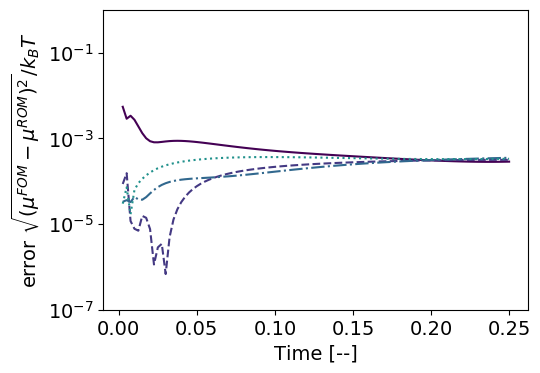

In [32]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.ticker import MaxNLocator
import numpy as np

fig, ax = plt.subplots(figsize=(5,4))

# Define the range of values for normalization and setup the colormap
points = np.arange(4)
normalize = mcolors.Normalize(vmin=points.min(), vmax=points.max()*2)
colormap = cm.viridis

# Define different line styles for each plot for visibility
line_styles = ['-', '--', '-.', ':']  # Additional custom dash pattern

ax.semilogy(t[1:], µ_err00[3], line_styles[0], color=colormap(normalize(points[0])), label='(X = 0, Y = 0)')
ax.semilogy(t[1:], µ_err052[3], line_styles[1], color=colormap(normalize(points[1])), label='(X = 0.25, Y = 1)')
ax.semilogy(t[1:], µ_err14[3], line_styles[2], color=colormap(normalize(points[2])), label='(X = 0, Y = 4)')
ax.semilogy(t[1:], µ_err12[3], line_styles[3], color=colormap(normalize(points[3])), label='(X = 0.25, Y = 3)')

ylabel = r'error $\sqrt{(\mu^{{FOM}} - \mu^{{ROM}})^2}/k_B T$'
# Set labels and other properties
ax.set_xlabel('Time [--]', fontsize=14)
ax.set_ylabel(ylabel, fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.xaxis.set_major_locator(MaxNLocator(nbins=6))

# Label lines with xvals for better placement
# labelLines([line for line in ax.get_lines() if 'ROM' not in line.get_label()], align=False, zorder=2.5, color="k", fontsize=14, xvals=[0.1 + i for i in range(4)])

# Set y-axis limits
ax.set_ylim(1e-7, 1e-0)  # Set y-axis limits

# Set title
# ax.set_title(title, fontsize=16)

# Add a legend if show_legend is True
# ax.legend(loc='best', fontsize=14, frameon= False, ncol=1)

plt.tight_layout()
plt.subplots_adjust(left=0.1, bottom=0.15, right=0.95, top=0.9)
file_name = 'results/ROM/bar/Fig_gel_bar_squared_error_mu_time_nestedPOD.pdf'
plt.savefig(file_name, bbox_inches='tight')
plt.show()

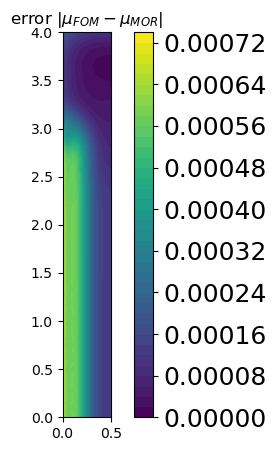

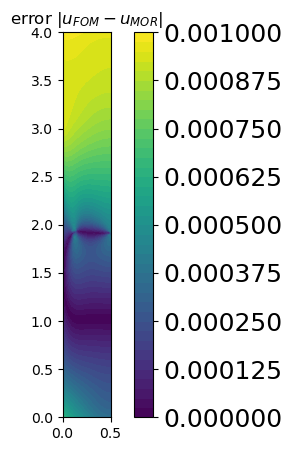

In [35]:
online_mu = (1558, 4000)
reduced_problem.set_mu(online_mu)
reduced_solution_opt = reduced_problem.solve()

# ROM for 8 RBs func
time_instance = 24
reduced_solution_at_time_instance_opt = reduced_solution_opt[time_instance]
reconstructed_reduced_solution_at_time_instance_opt = reduced_problem.basis_functions[:8] * reduced_solution_at_time_instance_opt
(uROM_time24_8, µROM_time24_8) = split(reconstructed_reduced_solution_at_time_instance_opt)

# uFOMx_time[time_instance]
# uFOMy_time[time_instance]
# print(len(uFOM_time))
# uFOM_time[time_instance]
# uROM_time24_6
# uROM_time24_6

plt.figure(figsize=(6,5))
# Create functions for the µ components
µ_full_func = Function(S.sub(1).collapse())
µ_reduced_func = project(µROM_time24_8, S.sub(1).collapse())

# Assign the components to these functions
assign(µ_full_func, µFOM_time[time_instance])

# Compute the error for the µ component
error_µ = Function(S.sub(1).collapse())
error_µ.vector()[:] = abs(µ_full_func.vector()[:] - µ_reduced_func.vector()[:])
p = plot(error_µ, title=r"error $\vert \mu_{{FOM}} - \mu_{{MOR}} \vert$", 
        # vmin=0.0, vmax=0.0065
        )
# Create colorbar with manually defined ticks
cbar = plt.colorbar(p, extend='both')
cbar.ax.tick_params(labelsize=18)
plt.show()

displacement_magnitude = sqrt(inner(uFOM_time[time_instance],uFOM_time[time_instance]))
displacement_magnitude_MOR = sqrt(inner(uROM_time24_8,uROM_time24_8))

plt.figure(figsize=(6,5))
# Create functions for the µ components
dips_mag_FOM = project(displacement_magnitude,S.sub(1).collapse())
dips_mag_MOR = project(displacement_magnitude_MOR,S.sub(1).collapse())
# print(len(dips_mag_FOM.vector()[:]))
# print(len(dips_mag_MOR.vector()[:]))
# print(dips_mag_FOM.vector()[:] - dips_mag_MOR.vector()[:])
error_u = Function(S.sub(1).collapse())
error_u.vector()[:] = abs(dips_mag_FOM.vector()[:] - dips_mag_MOR.vector()[:])
p = plot(error_u, title=r"error $\vert u_{{FOM}} - u_{{MOR}} \vert$", 
        # vmin=0.0, vmax=0.0075
        )
# Create colorbar with manually defined ticks
cbar = plt.colorbar(p, extend='both')
cbar.ax.tick_params(labelsize=18)
plt.show()